In [1]:
%pylab inline
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.models.rnn import rnn, rnn_cell
import numpy as np
import numpy.random as rng

import time

import pandas.io.data as web
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import seaborn

Populating the interactive namespace from numpy and matplotlib


In [91]:

def get_prices(symbol):
    start, end = '2007-05-02', '2016-04-11'
    data = web.DataReader(symbol, 'yahoo', start, end)
    data=pd.DataFrame(data)
    prices=data['Adj Close']
    prices=prices.astype(float)
    return prices

def get_returns(prices):
        return ((prices-prices.shift(-1))/prices)[:-1]
    
def get_data(list):
    l = []
    for symbol in list:
        rets = get_returns(get_prices(symbol))
        l.append(rets)
    return np.array(l).T
        
rets = get_data(['C'])#, 'GS'])

In [3]:
def lstm_iterator(raw_data, batch_size, num_steps, data_size):
 
  raw_data = np.array(raw_data, dtype=np.float32)

  data_len = len(raw_data)
  batch_len = data_len // batch_size
  data = np.zeros([batch_size, batch_len, data_size], dtype=np.float32)
  for i in range(batch_size):
    data[i] = raw_data[batch_len * i:batch_len * (i + 1),:]

  epoch_size = (batch_len - 1) // num_steps

  if epoch_size == 0:
    raise ValueError("epoch_size == 0, decrease batch_size or num_steps")

  for i in range(epoch_size):
    x = data[:, i*num_steps:(i+1)*num_steps]
    y = data[:, i*num_steps+1:(i+1)*num_steps+1]
    yield (x, y)

In [54]:
def run_epoch(session, m, data, eval_op, verbose=False, get_out=False):
  """Runs the model on the given data."""
  epoch_size = ((len(data) // m.batch_size) - 1) // m.num_steps
  start_time = time.time()
  costs = 0.0
  iters = 0
  state = m.initial_state.eval()
  output = []
  inp = []
  targ = []
  for step, (x, y) in enumerate(lstm_iterator(data, m.batch_size, m.num_steps, m.data_size)):
    cost, state, _ = session.run([m.cost, m.final_state, eval_op],
                                 {m.input_data: x,
                                  m.targets: y,
                                  m.initial_state: state})
    costs += cost
    #print(cost)
    iters += m.num_steps
    if get_out: 
      output.append(_)
      inp.append(x)
      targ.append(y)
    
  if len(output) > 0: 
    return output, inp, targ

  ''' if verbose and step % (epoch_size // 10) == 10:
      print("%.3f perplexity: %.3f speed: %.0f wps" %
            (step * 1.0 / epoch_size, np.exp(costs / iters),
             iters * m.batch_size / (time.time() - start_time)))
  '''
  return np.exp(costs / iters)



In [186]:
class SmallConfig(object):
    """Small config."""
    init_scale = 0.1
    learning_rate = 1.0
    max_grad_norm = 5
    num_layers = 4
    num_steps = 25
    hidden_size = 200
    max_epoch = 4
    max_max_epoch = 13
    keep_prob = 1.0
    lr_decay = 0.5
    batch_size = 20
    #vocab_size = 10000
    
class TestConfig(object):
  """Tiny config, for testing."""
  init_scale = 0.1
  learning_rate = 1.0
  max_grad_norm = 1
  num_layers = 4
  num_steps = 25
  hidden_size = 20
  max_epoch = 1
  max_max_epoch = 1
  keep_prob = 1.0
  lr_decay = 0.5
  batch_size = 20
  #vocab_size = 10000
  #data_size= 2

def get_config(test=False):
    if test:
        return TestConfig()
    return SmallConfig()

In [189]:
class LSTMModel(object):
    """The PTB model."""

    def __init__(self, is_training, config):
        self.batch_size = batch_size = config.batch_size
        self.num_steps = num_steps = config.num_steps
        self.data_size = data_size = config.data_size
        size = config.hidden_size
        
        
        matrix1 = tf.constant([[-1.,0.,1]])
        matrix2 = tf.ones([1,1])
        position_transform = tf.matmul(matrix2, matrix1)
        #position_transform = tf.constant([[-1.,0.,1]])
        
        # set PLACEHOLDERS
        self._input_data = tf.placeholder(tf.float32, [batch_size, num_steps, data_size])
        self._targets = tf.placeholder(tf.float32, [batch_size, num_steps, data_size])
        # set VARIABLES
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(size, forget_bias=0.0)
        cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell] * config.num_layers)
        cell = tf.nn.rnn_cell.InputProjectionWrapper(cell,  size)
        cell = tf.nn.rnn_cell.OutputProjectionWrapper(cell, 3*data_size)
        if is_training and config.keep_prob < 1:
            cell = tf.nn.rnn_cell.DropoutWrapper(
                cell, output_keep_prob=config.keep_prob)
        
        outputs = []
        self._initial_state = cell.zero_state(batch_size, tf.float32)
        state = self._initial_state
        with tf.variable_scope("RNN"):
            for time_step in range(num_steps):
                if time_step > 0: tf.get_variable_scope().reuse_variables()
                    
                (cell_output, state) = cell(tf.reshape(self._input_data[:, time_step,:], [-1, data_size]), state)
                outputs.append(tf.nn.softmax(cell_output))
        self._output = output = tf.concat(0, outputs)    # shape: [500, 3]   =   [??, data_size*3]
        self._final_state = state    #shape: [20,160]    =     [hidden size, ??]
        
        target_menu = tf.matmul(tf.reshape(self._targets, [-1,1]), position_transform)
        target_menu = tf.reshape(target_menu, [-1,3*data_size])    #   shape: [500, 3]    =   [??, data_size*3]
        
        drets = tf.mul(target_menu, output)   # shape: [500, 3]   =   [??, data_size*3]
        max_possible_ret = tf.reduce_max(target_menu, 1)  # shape: [500]

        position = tf.cast(tf.argmax(output, 1) - 1, tf.float32)
        drets_position = tf.mul(position, tf.reshape(self._targets, [-1]))
        
        
        print(drets_position)
        #ret = tf.matmul(tf.reshape(output, [1,-1]),tf.reshape(self._targets, [-1,1]))
        #print(ret)

        #set LOSS
        '''loss = tf.nn.seq2seq.sequence_loss_by_example(
        [outputs],
        [tf.reshape(self._targets, [-1,1])],
        [tf.ones([batch_size * num_steps])],
        2)'''     #
        loss=max_possible_ret-tf.reduce_sum(drets,1)#tf.nn.l2_loss(output - tf.reshape(self._targets, [-1, 1]))
        #loss= max_possible_ret - drets
        
        #set COST
        self._cost = cost = tf.reduce_sum(loss) / batch_size
        
        #print(cost.eval())
        
        if not is_training:
            return
        #TRAINING STEP
        self._lr = tf.Variable(0.0, trainable=False)
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars),
                                      config.max_grad_norm)
        optimizer = tf.train.AdamOptimizer(self.lr)#GradientDescentOptimizer(self.lr)
        self._train_op = optimizer.apply_gradients(zip(grads, tvars))
        
        
        
        #####TODO
        # make sure that state rolls over to next batch
        # whats up with grads?
        # need softmax!
        #normalize input (might help nonaction problem)
        #try lm nn at the end, see line 31 of https://github.com/sherjilozair/char-rnn-tensorflow/blob/master/model.py
        # seq2seq.rnn_decoder and seq2seq.sequence_loss_by_example

    def assign_lr(self, session, lr_value):
        session.run(tf.assign(self.lr, lr_value))

    @property
    def input_data(self):
        return self._input_data

    @property
    def targets(self):
        return self._targets

    @property
    def initial_state(self):
        return self._initial_state

    @property
    def cost(self):
        return self._cost

    @property
    def final_state(self):
        return self._final_state

    @property
    def lr(self):
        return self._lr

    @property
    def train_op(self):
        return self._train_op
    
    @property
    def output(self):
        return self._output



In [190]:

raw_data = rets[:1500], rets[:2200], rets[2200:]
train_data, valid_data, test_data = raw_data
#train_data =valid_data = test_data =  raw_data

config = eval_config = get_config()
eval_config = get_config(test=True)
eval_config.batch_size = 1
eval_config.num_steps = 1

config.data_size = eval_config.data_size = rets.shape[1]

with tf.Graph().as_default(), tf.Session() as session:
    initializer = tf.random_uniform_initializer(-config.init_scale,
                                            config.init_scale)
    with tf.variable_scope("model", reuse=None, initializer=initializer):
        m = LSTMModel(is_training=True, config=config)
    with tf.variable_scope("model", reuse=True, initializer=initializer):
        mvalid = LSTMModel(is_training=False, config=config)
        #mtest = LSTMModel(is_training=False, config=eval_config)

    tf.initialize_all_variables().run()

    for i in range(config.max_max_epoch):
        lr_decay = config.lr_decay ** max(i - config.max_epoch, 0.0)
        m.assign_lr(session, config.learning_rate * lr_decay)

        print("Epoch: %d Learning rate: %.3f" % (i + 1, session.run(m.lr)))
        train_perplexity = run_epoch(session, m, train_data, m.train_op,
                                   verbose=True)

        print("Epoch: %d Train Perplexity: %.3f" % (i + 1, train_perplexity))
        valid_perplexity = run_epoch(session, mvalid, valid_data, tf.no_op())
        print("Epoch: %d Valid Perplexity: %.3f" % (i + 1, valid_perplexity))

    test_output, test_inp, test_targ = run_epoch(session, mvalid, valid_data, mvalid.output, get_out = True)
    #print(test_perplexity)
    #print("Test Perplexity: %.3f" % test_perplexity)


Tensor("model/Mul_1:0", shape=TensorShape([Dimension(500)]), dtype=float32)
Tensor("model_1/Mul_1:0", shape=TensorShape([Dimension(500)]), dtype=float32)
Epoch: 1 Learning rate: 1.000
Epoch: 1 Train Perplexity: 1.028
Epoch: 1 Valid Perplexity: 1.023
Epoch: 2 Learning rate: 1.000
Epoch: 2 Train Perplexity: 1.028
Epoch: 2 Valid Perplexity: 1.023
Epoch: 3 Learning rate: 1.000
Epoch: 3 Train Perplexity: 1.028
Epoch: 3 Valid Perplexity: 1.023
Epoch: 4 Learning rate: 1.000
Epoch: 4 Train Perplexity: 1.028
Epoch: 4 Valid Perplexity: 1.023
Epoch: 5 Learning rate: 1.000
Epoch: 5 Train Perplexity: 1.028
Epoch: 5 Valid Perplexity: 1.023
Epoch: 6 Learning rate: 0.500
Epoch: 6 Train Perplexity: 1.028
Epoch: 6 Valid Perplexity: 1.023
Epoch: 7 Learning rate: 0.250
Epoch: 7 Train Perplexity: 1.028
Epoch: 7 Valid Perplexity: 1.023
Epoch: 8 Learning rate: 0.125
Epoch: 8 Train Perplexity: 1.028
Epoch: 8 Valid Perplexity: 1.023
Epoch: 9 Learning rate: 0.062
Epoch: 9 Train Perplexity: 1.028
Epoch: 9 Valid 

In [164]:
np.argmax(x,1)-1

array([-1, -1, -1, -1,  0, -1,  0, -1, -1, -1])

In [167]:
x = np.random.random([10,1])
y= np.random.random([10,1])

In [169]:
x * y

array([[ 0.01011717],
       [ 0.00543042],
       [ 0.06012374],
       [ 0.54723903],
       [ 0.52666874],
       [ 0.01286158],
       [ 0.47726873],
       [ 0.27279065],
       [ 0.67786316],
       [ 0.11310315]])

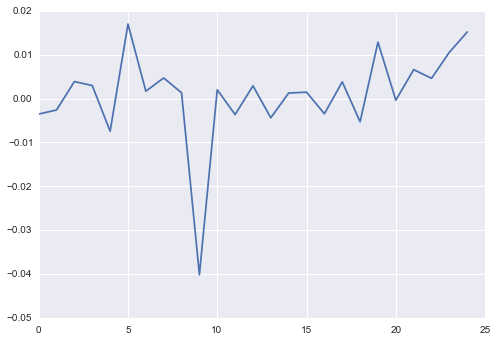

In [191]:
plot(test_inp[0][0])

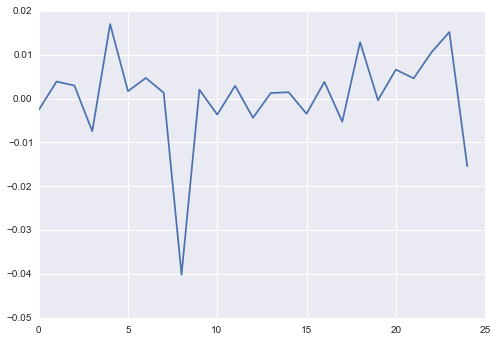

In [192]:
plot(test_targ[0][0])

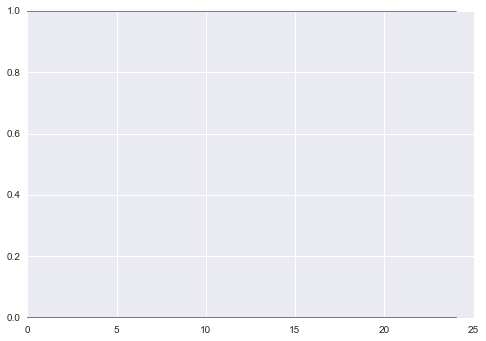

In [193]:
x=3
n = 6
plot(test_output[0][25*x*1:25*1*(x+1)].reshape(-1,3))

In [41]:
inv = test_output[0][25*x*1:25*1*(x+1)].reshape(-1,6)

In [235]:
test_output[0][0:25*6].reshape(-1,6).shape

(150, 6)

In [256]:
np.mul(inv[:,:])

AttributeError: 'module' object has no attribute 'mul'

In [42]:
np.sum(inv,1)

array([ -6.98216486,  -6.98215246,  -6.98232746,  -6.98221302,
        -6.98204231,  -6.98219585,  -6.98207426,  -6.98217106,
        -6.98215723,  -6.98219633,  -6.98216343,  -6.98217678,
        -6.98221302,  -6.98215961,  -6.98213148,  -6.9821701 ,
        -6.98215151,  -6.98215818,  -6.98216295,  -6.98211956,
       -14.57940769, -14.57942486, -14.57956505, -14.57947636, -14.57931995], dtype=float32)